Контакты:
    **почта:** a.polushkin@tbank.ru
    **tg** @username_1233

# Курс "Управление рисками"
# Семинар 4: Линейная регрессия на примере предсказания дохода

## Часть 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
# import holoviews as hv
# hv.extension('matplotlib')

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./income_dataset.csv',sep=';')
df.head()

,id,in_total_amt,income,job_salary,gender,age,car_own_flg,avg_limit,max_limit,credit_num,acc_num,out_total_amt
0,0,8110.825000,30000.0,32000,1,22.0,0,12847.00000,23862.0,7,9.0,38657.606406
1,1,25600.000000,50000.0,32000,0,26.0,0,26381.50000,24611.0,3,7.0,51272.839585
2,2,216091.400000,30000.0,38000,0,25.0,0,9176.48857,33998.0,14,3.0,147950.296174
3,3,106000.661389,50000.0,40000,0,36.0,0,32152.50000,23451.0,4,6.0,99925.392161
4,4,102672.375000,50000.0,17000,0,23.0,0,38493.50000,585000.0,9,7.0,78125.045718


In [3]:
len(df)

55200

#### Описание признаков

- id - уникальный id клиента
- in_total_amt - среднемесячные пополнения карты 
- gender - пол (1 - женский, 0 - мужской)
- age - возраст
- car_own_flg - наличие авто
- avg_limit - средняя сумма кредита
- max_limit - максимальная сумма кредита
- job_salary - средняя зарплата по должности
- credit_num - количество кредитов
- acc_num - количество счетов
- out_total_amt - среднемесячные траты

**Целевая переменная:** income

#### Предварительный отбор

Для начала внимательно изучим признаки. В данных есть уникальное для каждого объекта поле id. 
Нужно удалить это поле, так как оно способствуют переобучению.

**Вопрос:** Почему поля типа id могут вызвать переобучение модели?

Не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

In [4]:
numeric = [ 'in_total_amt', 'avg_limit', 'job_salary','gender'] # остальные признаки попадают в домашнее задание

#### Разделение выборки на обучающую и тестовую

Нам нужно обучить модель линейной регрессии и провалидировать ее (убедиться, что модель продолжает работать). Для этого используют обучающую и тестовую выборки (кроме этого выделяют и валидационную выборку - для настройки гиперпараметров, например в случае Ридж- и Лассо-регресии). 

Обычно обучающую и тестовую выборки получают разделением выборки на две подвыборки в каком-то соотношении (например 80% - трейн, 20% - тест). Сделать это можно:
- случайно (метод *train_test_split* в sklearn.model_selection)
- по времени (упорядочить выборку по id и разделить в соотношении)

**Вопрос:** В каких случаях нам может быть важно поделить выборку случайно, а в каких - по времени? 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[numeric], df['income'], test_size=0.3, shuffle=False) # shuffle=False - делим по времени

#### Построим модель

Попробуем обучить модель линейной регрессии на "сырых" данных и посчитать метрику $R^2$.

In [6]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def fit_predict(X_train, y_train, X_test, y_test, predictor_list):
    model = LinearRegression()
    model.fit(np.array(X_train[predictor_list]),y_train)
    prediction = model.predict(X_test[predictor_list])
    message = (
    f"R2_train: {round(r2_score(y_train, model.predict(X_train[predictor_list])),4)}\n"
    f"R2_test: {round(r2_score(y_test,prediction), 4)}")

    print(message)
    return prediction

In [7]:
fit_predict(X_train, y_train, X_test, y_test, numeric);

R2_train: 0.1587
R2_test: 0.1107


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Видим, что метрика $R^2$ на обучающей выборке $0.1587$, а разница между метриками на обучающей и тестовой выборках $0.048$.

#### Целевая переменная (Таргет)

Построим гистограмму распределения целевой переменной:

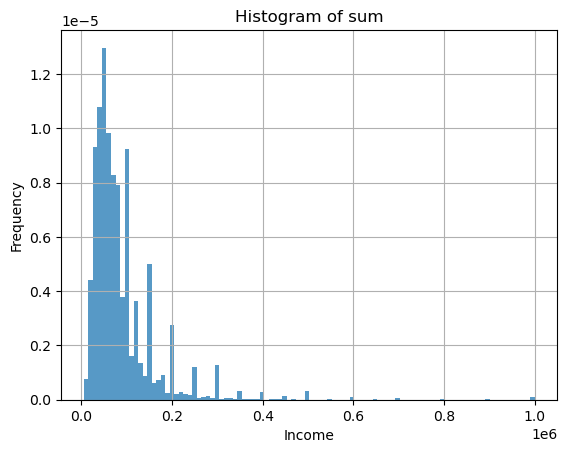

In [8]:
n, bins, patches = plt.hist(y_train, 100, density=True, alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

На гистограмме видим длинный хвост распределения. 

**Вопрос:** Почему нужно убрать выделяющиеся наблюдения?

Подсказка: Какую функцию минимизируем при вычислении оценок коэффициентов? Что произойдет, если вычислим ее на большом значении целевой переменной? Как это повлияет на модель?

Исключим из обучающей выборки наблюдения, попадающие за 95-квантиль распределения:

In [9]:
X_train = X_train[y_train <= np.percentile(y_train, 95)]
y_train = y_train[y_train <= np.percentile(y_train, 95)]


Вычислим логарифм дохода:

In [10]:
y_train = np.log(y_train.clip(lower=1)) 
y_test =  np.log(y_test.clip(lower=1)) 

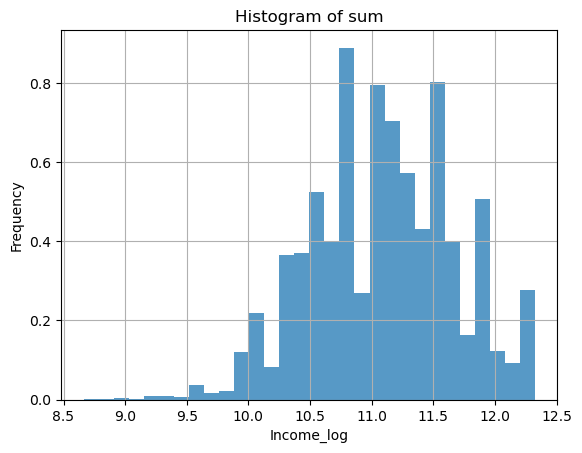

In [11]:
n, bins, patches = plt.hist(y_train, 30, density=True, alpha=0.75)
plt.xlabel('Income_log')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

---

Немного про обучение модели линейной регрессии.

Для обучения модели линейной регрессии будем использовать sklearn: в нем понятный и простой интерфейс. Также можно использовать statsmodels (в нем более обширный функционал и реализованы статистические тесты).

В sklearn есть несколько классов, реализующих линейную регрессию:

- LinearRegression — "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $$a=(𝑋^𝑇𝑋)^{−1}𝑋^𝑇𝑦$$
- Ridge — линейная регрессия с оптимизацией MSE и ℓ2-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и ℓ1-регуляризацией


У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй (вызываем после метода fit) возвращает предсказание на выборке. 

## Часть 2. Подготовка данных для применения модели

На лекции мы обсудили предположения, в которых уместно применять модель линейной регрессии: $X^TX$ - невырожденная матрица, 
𝑦 линейно зависит от $x$, остатки $\varepsilon_i$ независимы и $\varepsilon_i \sim N(0,\sigma)$.

На практике эти предположения гарантируются при выполнении условий:
 
1. **Линейность зависимости предикторов и таргета**

2. **Гомоскедастичность**
	$$De = \sigma^{2}I$$
    
3. **Нормальность ошибок**
	$$e \sim N_{n}(0,\sigma^{2}I)$$

4. **Отсутствие мультиколлинеарности**
	$$rank(X) = m + 1 $$

### Линейность зависимости

При постановке задачи мы сделали предположение о линейной зависимости целевой переменной $y$ от предикторов $x_i$. 

Проверить линейность можно графически. Для этого нужно визуализировать\* зависимость между предиктором и целевой переменной (например, с помощью диаграммы рассеивания).


\* При слишком большом количестве точек они обычно группируются по бакетам.

В качестве метрики оценки линейности признака можно использовать $R^2$ простой линейной регрессии на выбранном признаке относительно целевой переменной. 

#### Scatterplot

Построим диаграмму рассеивания для некоторых признаков:

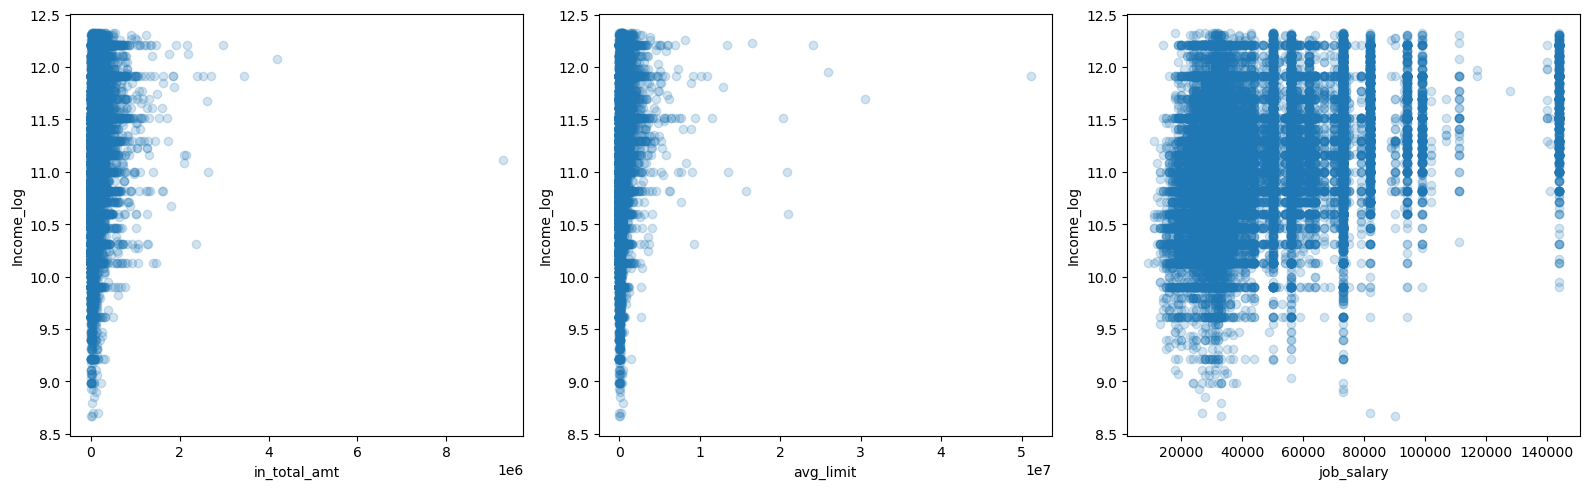

In [12]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['in_total_amt','avg_limit','job_salary']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Income_log")
plt.tight_layout()
plt.show()

### Feature_line

В случае, когда наблюдений очень много (как в нашей выборке), можно разбить признак по бакетам и построить среднее и квантили целевой переменной для каждого бакета. Такую визуализацию будем называть feature_line. 

Алгоритм построения feature_line:

1. Сгруппируем наблюдения по бакетам признака (бакеты одного размера, для непрерывных признаков можем использовать количество бакетов nbins > 10) 

2. Вычислим среднее значение целевой переменной для каждого бакета признака (соединим их пунктирной линией) 

3. Для каждого бакета добавим квантили $0.25$ и $0.75$ (обозначим вертикальными линиями)



![feature_line_.png](feature_line_.png)

И выведем гистограмму распределения признака:

![feature_line_hist_.png](feature_line_hist_.png)

Feature_line позволяет оценить характер зависимости целевого признака от предиктора. 
На примере feature_line признака in_total_amt видно, что зависимость не линейная, у распределения длинный хвост (крайний бакет расположен около точки 380000), значения целевой переменной как будто "загибаются" при больших значениях признака.

$R^2=0.055$

[Задание 1](#task1)

### Преобразования

Когда признак нелинейный, может помочь:
- непрерывное монотонное преобразование, линеаризующее признак (это может быть логарифмирование, возведение в квадрат и т.д. В частных случаях бывают и другие типы функций,например, парабола)
- разбиение переменной на линейные фрагменты

**Вопрос:** Почему важна монотонность преобразования?

Лианеризуем признак in_total_amt. Для преобразования этого признака выберем функцию логарифма.

![feature_line_log.png](feature_line_log.png)

Гистограмма распределения признака выглядит так

![feature_line_log_hist.png](feature_line_log_hist.png)

Видно, что признак "распрямился". Значение метрики $R^2$ так же увеличилось.

### Ограничения значений признака

На графике feature_line для непреобразованного значения видно, что наблюдения из хвоста распределения сгруппированы в крайний бакет с серединой ~380000. Можем ограничить экспертно значением 400000.

На графике feature_line логарифмированного признака видно, что слева значение целевой переменной находится на "плато". Линейной зависимости в этом случае не будет. Ограничим признак снизу, например значением 3000. 

**Вопрос:** Можем ли ограничить признак "сильнее"? 

![feature_line_log_limit.png](feature_line_log_limit.png)

![feature_line_log_limit_hist.png](feature_line_log_limit_hist.png)

Видим, что метрика $R^2$ увеличилась на $0.02$.

Сохраним значения преобразованного признака:

In [13]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'].clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'].clip(lower=3000, upper=400000))

[Задание 2](#task2)

### Проверим гомоскедастичность

Необходимо проверить, что признаки гомоскедастичны, то есть дисперсия ошибки константна на всем предсказании и формально
$$De = \sigma^{2}I$$
Нарушение данного условия приводит к неэффективности оценок регрессии и несоответствию оценок МНК и ОМП

**Способы проверки**: 
- построить график зависимости остатка от предсказания (по необходимости с разбиением на бакеты)
- зависимость разброса от предсказания будет свидетельствовать о гетероскедастичности  
- статистические тесты (к сожалению, универсального нет - каждый позволяет найти гетероскедастичность только определенного вида)

**Способы решения проблемы**
- Преобразование целевой переменной, приводящее к равномерности разброса
- В случае диагональности матрицы ковариаций возможно применение обощенного [МНК]

  $$\hat{a} = (X^{T}\Omega^{-1}X)^{-1}X^{T}\Omega^{-1}y, \;где\; \Omega^{-1} - матрица\; ковариаций\; остатков$$

Мы уже преобразовали целевую переменную (логарифмированием). Поэтому проверим, что было до преобразования переменной и признака in_total_amt, и сравним с тем, что стало после.

#####  Графический тест
Гетероскедастичность будет наблюдаться, если при изменении предсказания будет меняться величина разброса 

In [14]:
def get_residuals(Y,Pred):
    '''Подсчет невязки Y - истинное значение таргета, Pred - предсказанное'''
    return Y - Pred

In [15]:
def check_homoscedacity(predictor,target,f_name):
    simple_model = LinearRegression()
    simple_model.fit(predictor.reshape(-1,1),target)
    predicts = simple_model.predict(predictor.reshape(-1,1))
    return (plt.scatter(predicts,get_residuals(target,predicts)))

Визуализируем зависимость для предсказания линейной регрессии от непреобразованного признака in_total_amt и целевой переменной:

In [16]:
def make_bucket(df,feature, n =  100):
    '''функция, бьющая на бакеты(по умолчанию 100 точек)'''
    return df.assign(bucket = np.ceil(df[feature].rank(pct = True) * n))

In [17]:
def plot_homoscedacity(predictor, target, predictor_name='feature'):
    df_tmp = pd.DataFrame({'predictor':predictor, 'target':target})
    return df_tmp.pipe(make_bucket,'predictor',200)\
                 .groupby(by = ['bucket']).mean()\
                 .pipe(lambda x:check_homoscedacity(np.array(x.predictor),np.array(x.target),predictor_name)) 

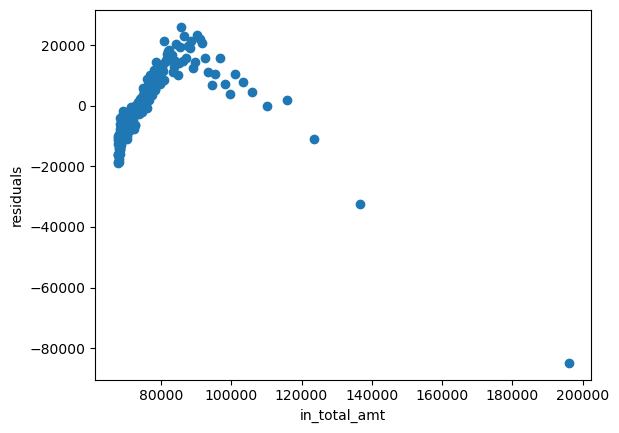

In [18]:
plot_homoscedacity(X_train.in_total_amt, np.exp(y_train),'in_total_amt')
plt.xlabel('in_total_amt')
plt.ylabel('residuals')
plt.show()

Видно, что для признака in_total_amt гомоскедастичность не выполнена (остатки зависят от значения предсказания)

Визуализируем зависимость для предсказания линейной регрессии для преобразованного признака in_total_amt_log и преобразованной целевой переменной:

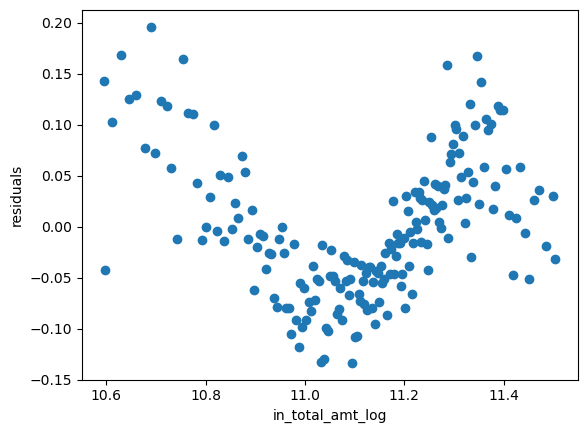

In [19]:
plot_homoscedacity(X_train.in_total_amt_log, y_train,'in_total_amt_log')
plt.xlabel('in_total_amt_log')
plt.ylabel('residuals')
plt.show()

[Задание 3](#task3)

### Нормальность остатков

Необходима для эквивалентности оценок МНК и ОМП

**Способы проверки**
- Статистические критерии
- Построение гистограммы распределения ошибок простой линейной регрессии по признакам или всей модели
- Построение графика QQ-plot (https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

**Способы решения проблемы**
- преобразование признака, приводящее к нормальному распределению
- исключение признака из регрессии

In [20]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


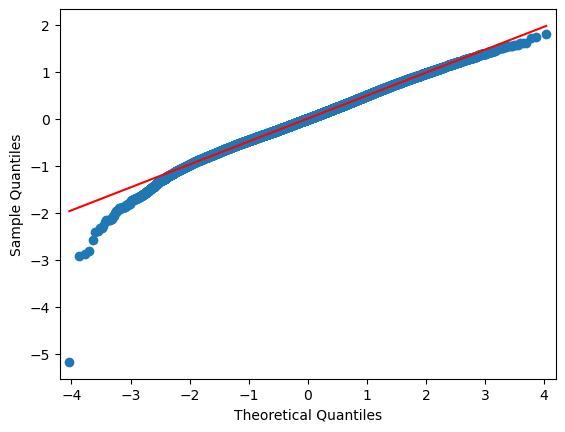

In [21]:
import statsmodels.api as sm
import pylab as py

model = LinearRegression()
model.fit(np.array(X_train[numeric_final]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric_final])))
  
# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code 
# the graph look different than shown below.
  
# Random data points generated
data_points = np.random.normal(0, 1, 100000)    
  
sm.qqplot(np.array(resids), line='s')
py.show()

На этом графике qq-plot видно, что точки не лежат на прямой. Посмотрим на гистограмму распределения остатков.

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


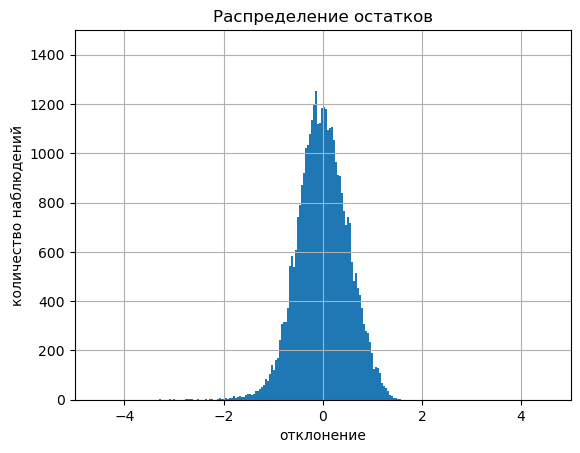

In [22]:
model = LinearRegression()
model.fit(np.array(X_train[numeric]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric])))
plt.hist(resids, bins='auto')[2]
plt.xlabel('отклонение')
plt.ylabel('количество наблюдений')
plt.title('Распределение остатков')
plt.axis([-5, 5, 0, 1500])
plt.grid(True)
plt.show()

Если внимательно посмотреть на распределение, можно увидеть небольшую ассиметричность: "хвосты" распределения немного отличаются.
    
На qq-plot это легко увидеть - в левой части графика точки находятся ниже прямой, т.е. квантили выборочного распределения смещены относительно теоритическиx.

### Мультиколлинеарность

Мультиколлинеарность - проблема близости матрицы X к какой-либо матрице неполного ранга (то есть сильной зависимости признаков между собой).В этом случае матрица $X^TX$ будет плохо обусловленной и решения будут неустойчивыми.

Проверить отсутствие мультиколлинеарности можно:
1. Построив корреляционную матрицу. Если значение коэффициента корреляции >0.3 следует более подробно изучить коррелирующие признаки и преобразовать их или исключить менее эффективный
    
2. Вычислив VIF (Variance Inflation Factor)

#### Проверка коэффициентов корреляции между парами признаков

Проверим, есть ли коррелирующие переменные с выборочным коэффициентов корреляции $>0.3$. Для этого построим матрицу корреляций:

/var/folders/z_/d0y9gfdn1w5475vgs7zb15ph0000gn/T/ipykernel_7356/165153338.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


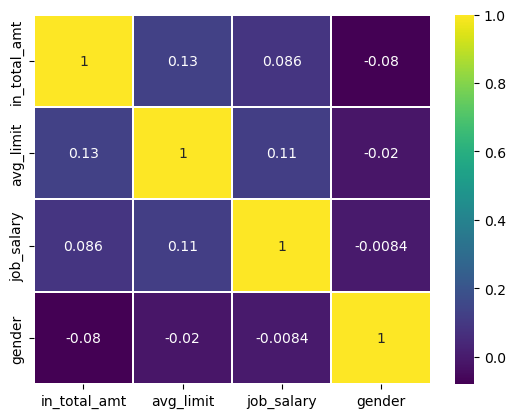

In [23]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

pcorr = pd.DataFrame 
pcorr = []
for f1 in numeric:
    for f2 in numeric:
        pcorr.append((f1,f2,pearsonr(X_train[f1],X_train[f2])))
        
cor = X_train.loc[:,numeric].corr(method='pearson')
cm=plt.cm.viridis
sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

Видим, что коэффициенты корреляции небольшие (меньше 0.3). 

#### Variance Inflation Factor

Variance Inflation Factor (VIF) позволяет обнаружить корреляцию признака со всеми остальными в совокупности. 

Для вычисления VIF строится k моделей линейной регрессии (здесь k - это количество признаков).

 - i-ый признак выбирается как целевая переменная, оставшиеся признаки - как предикторы. Строится модель линейной регрессии.
 - для предсказанных значений вычисляем VIF:
$$VIF_{i} = \frac{1}{1 - R^{2}_{i}}$$

**Вопросы**: 
   - При каких значениях VIF есть подозрение на линейную зависимость?

Вычислим значение Variance Inflation Factor для признаков:

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame(data = {'feature':[i for i in numeric],
                     'VIF':[round(variance_inflation_factor(X_train[numeric].values,i),2) for i in range(len(numeric))]}).set_index('feature')

,VIF
feature,
in_total_amt,1.40
avg_limit,1.18
job_salary,1.87
gender,1.38


[Задание 4](#task3)

## Baseline

Построим Baseline

In [25]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

In [26]:
fit_predict(X_train, y_train, X_test, y_test, numeric_final);

R2_train: 0.2627
R2_test: 0.2741


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


[Задание 5](#task5)

## Качество модели

Немного про интерпретацию $R^2$.

### Интерпретация $R^2$:

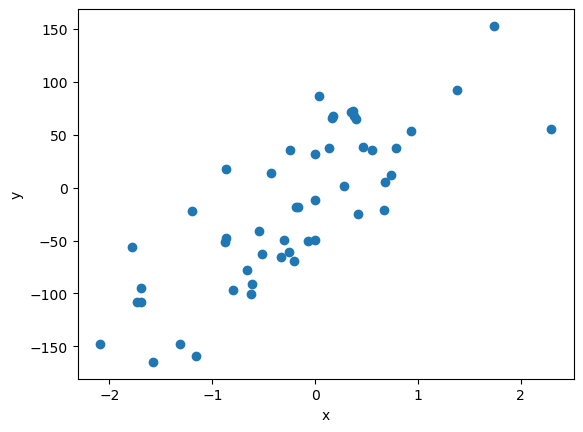

In [27]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=50, n_features=1, n_informative=1, noise=50, random_state=89)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y");

На лекции мы говорили, что метрика $R^2$ означает долю объясненной с помощью линейной модели дисперсии $y$. Разберемся с этим определением подробнее.

Дисперсия – это средний квардрат разброса наблюдений вокруг выборочного среднего:

In [28]:
message = (
    f"Variance by definition: {np.mean( (y - np.mean(y)) ** 2 )}\n"
    f"Variance using function: {np.var(y, ddof=0)}"  # ddof=0 означает, что в знаменателе будет n-0, а не n-1
)

print(message)

Variance by definition: 5283.500549191376
Variance using function: 5283.500549191376


Визуализируем разброс: 

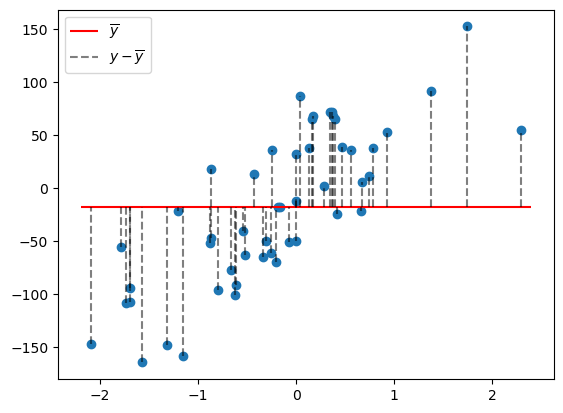

In [29]:
plt.scatter(X, y)

# средний y
plt.hlines(y=np.mean(y), xmin=-2.2, xmax=2.4, color="r", label=r"$\overline{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, np.mean(y))
ymax = np.maximum(y, np.mean(y))

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \overline{y}$")

plt.legend();
plt.show()

Итак, дисперсия – это сумма квадратов отклонений от среднего (пунктирная линия). Теперь попробуем теперь расчитать **разброс вокруг линии регрессии**:

In [30]:
coef = np.linalg.inv( X.T @ X ) @ X.T @ y  # коэффициенты линейной регрессии
reg_line = X @ coef                        # линия регрессии

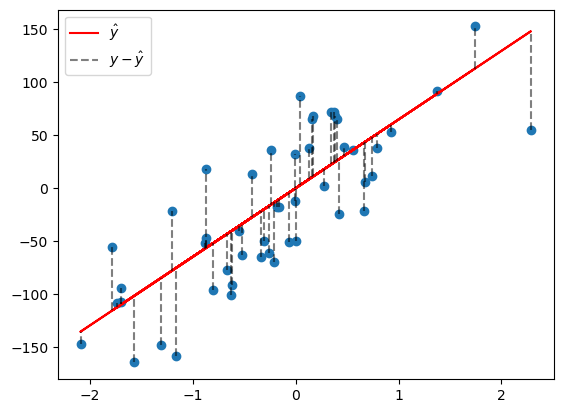

In [31]:
plt.scatter(X, y)
plt.plot(X, reg_line, color="r", label=r"$\hat{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, reg_line)
ymax = np.maximum(y, reg_line)

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \hat{y}$")

plt.legend()
plt.show()

Итак, мы построили такой же график с разбросом вокруг регрессионной прямой, как и вокруг среднего. Можно заметить, что ошибка в среднем стала меньше – **длины пунктирных линий уменьшились**. Метрика $R^2$ и отвечает на вопрос, насколько в среднем уменьшилась ошибка при переходе от предсказания выборочным средним к регрессии:

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

 - если $R^2 = 0$, это означает, что $\sum (y - \hat y) ^ 2 = \sum (y - \overline y) ^ 2$ – линейная регрессия предсказывает так же, как и выборочное среднее.
 - если $R^2 = 1$, это означает, что $\sum (y - \hat y) ^ 2 = 0$ – все наблюдения расположены на регрессионной прямой.ь

**Вопрос**: Может ли $R^2$ быть отрицательным?

 [Задание 6](#task6)

## Домашнее задание 2: Линейная регрессия
### (10 баллов)

<a id='task1'></a>
### Задание 1 (3 балла)

1. Реализовать функцию feature_line(var, target, nbins)

    В качестве аргументов функция должна принимать:
     - var: вектор значений признака
     - target: вектор значений целевой переменной
     - nbins: количество бакетов

    и возвращать:
     - график линейности признака
     - количество удаленных наблюдений
     - значение метрики R2
     - гистограмму распределения признака
 
 
2. Проверить линейность признаков с помощью функции feature_line()

In [32]:
plt.style.use('default')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55200 entries, 0 to 55199
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             55200 non-null  int64  
 1   in_total_amt   55200 non-null  float64
 2   income         55200 non-null  float64
 3   job_salary     55200 non-null  int64  
 4   gender         55200 non-null  int64  
 5   age            55200 non-null  float64
 6   car_own_flg    55200 non-null  int64  
 7   avg_limit      55200 non-null  float64
 8   max_limit      55200 non-null  float64
 9   credit_num     55200 non-null  int64  
 10  acc_num        55200 non-null  float64
 11  out_total_amt  55200 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 5.1 MB


In [33]:
features = df.drop(['id', 'income'], axis=1).columns.to_list()
features

['in_total_amt',
 'job_salary',
 'gender',
 'age',
 'car_own_flg',
 'avg_limit',
 'max_limit',
 'credit_num',
 'acc_num',
 'out_total_amt']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.3, shuffle=False)
X_train = X_train[y_train <= np.percentile(y_train, 95)]
y_train = y_train[y_train <= np.percentile(y_train, 95)]
y_train = np.log(y_train.clip(lower=1))
y_test =  np.log(y_test.clip(lower=1))

In [35]:
def feature_line(feature, target, nbins=11):
    df_tmp = pd.DataFrame({"feature": feature, "target": target}).copy()
    before = len(df_tmp)
    df_tmp = df_tmp.replace([np.inf, -np.inf], np.nan).dropna()
    removed = before - len(df_tmp)

    df_tmp["bucket"] = np.ceil(df_tmp["feature"].rank(pct=True) * nbins).astype(int)
    df_tmp["bucket"] = df_tmp["bucket"].clip(1, nbins)

    agg = (df_tmp.groupby("bucket").agg(
        feature_mean=("feature", "mean"),
        target_mean=("target", "mean"),
        q25=("target", lambda x: np.quantile(x, 0.25)),
        q75=("target", lambda x: np.quantile(x, 0.75)),
        cnt=("target", "size")
    ).reset_index().sort_values("feature_mean"))
    X = df_tmp["feature"].values.reshape(-1, 1)
    y = df_tmp["target"].values
    lr_raw = LinearRegression().fit(X, y)
    r2 = r2_score(y, lr_raw.predict(X))
    Xb = agg["feature_mean"].values.reshape(-1, 1)
    yb = agg["target_mean"].values
    lr_bucket = LinearRegression().fit(Xb, yb)

    plt.figure(figsize=(9, 4))
    plt.plot(agg["feature_mean"], agg["target_mean"], linestyle="--", marker="o")

    for i, row in agg.iterrows():
        plt.vlines(row["feature_mean"], row["q25"], row["q75"])

    x_grid = np.linspace(Xb.min(), Xb.max(), 200)
    y_grid = lr_bucket.predict(x_grid.reshape(-1, 1))
    plt.plot(x_grid, y_grid, label="Linear regression (buckets)")
    plt.legend()

    plt.xlabel("feature")
    plt.ylabel("target")
    plt.title(f"feature_line: nbins={nbins}, R2={r2:.3f}, removed={removed}")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.hist(df_tmp["feature"], bins="auto", density=True, alpha=0.75)
    plt.title("Hist of feature")
    plt.grid(True)
    plt.show()
    return removed, r2



Feature: in_total_amt


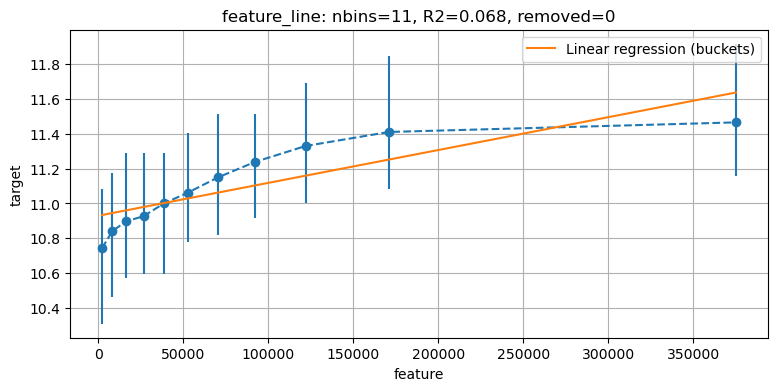

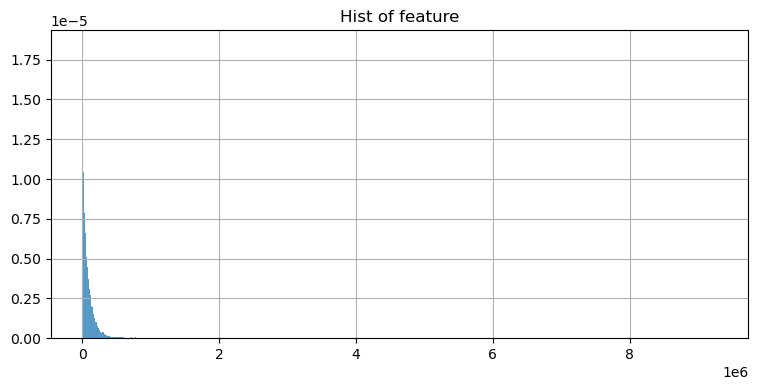


Feature: job_salary


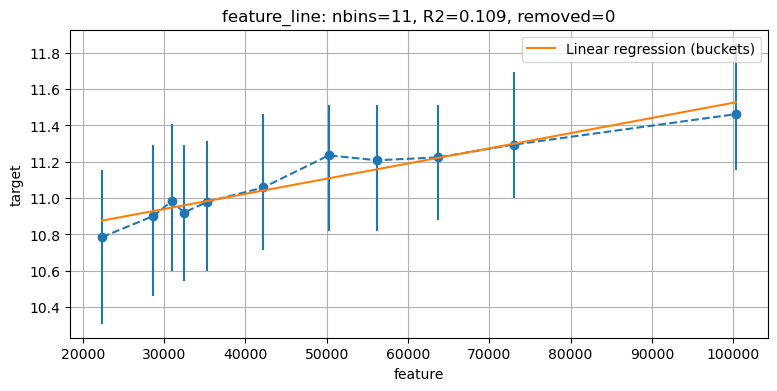

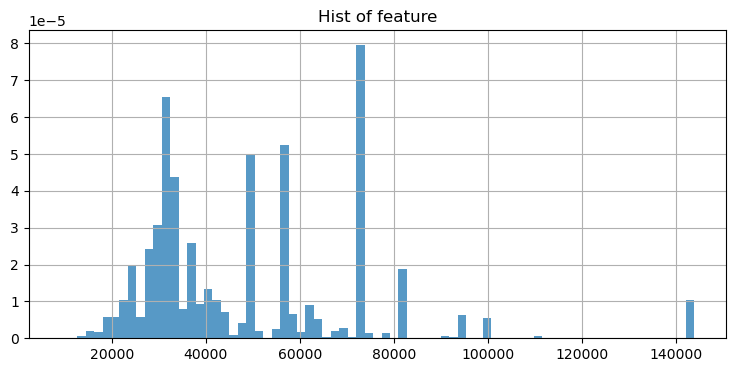


Feature: age


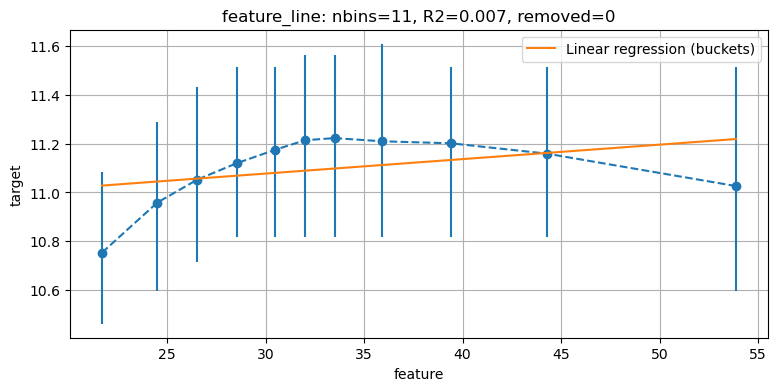

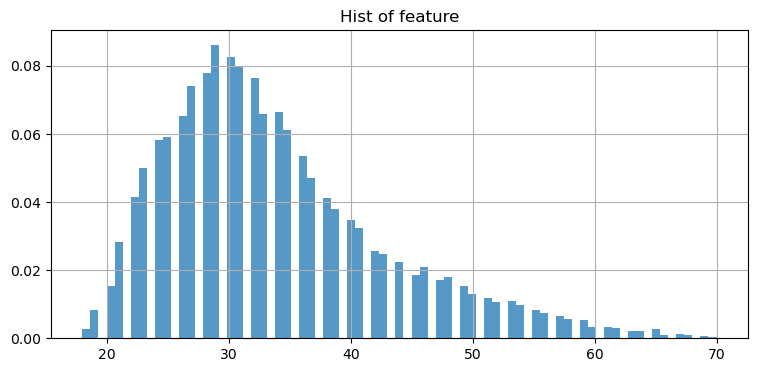


Feature: avg_limit


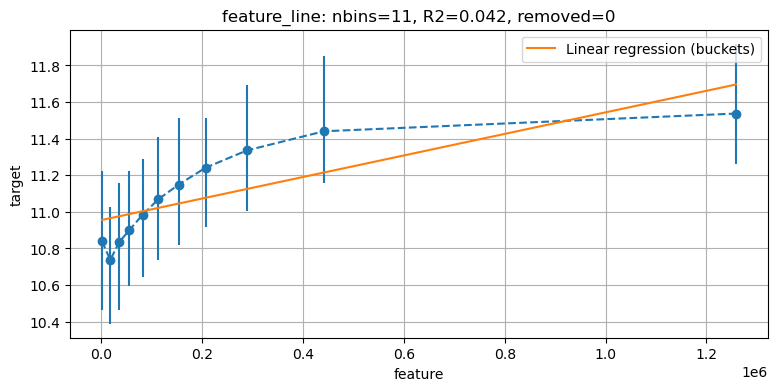

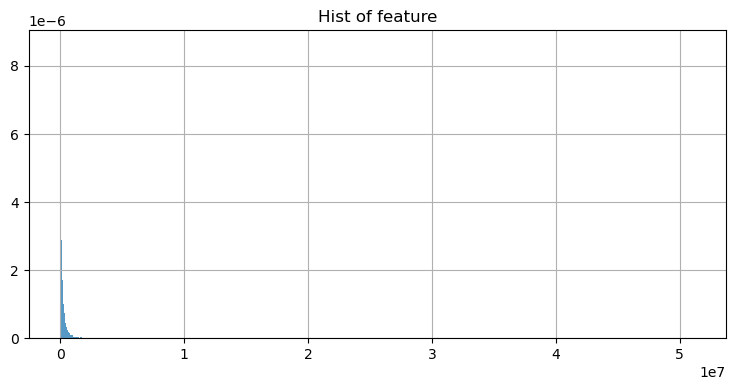


Feature: max_limit


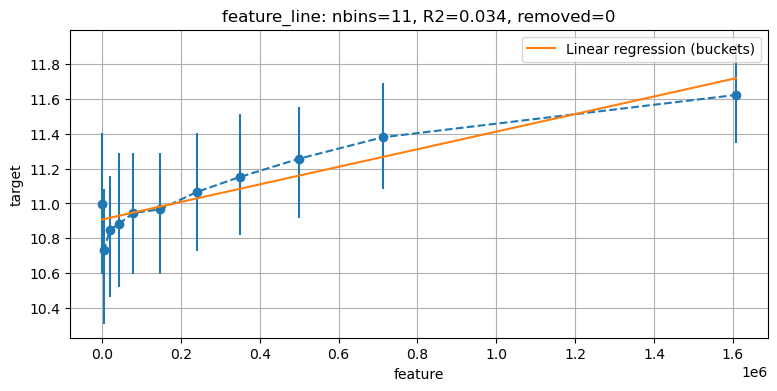

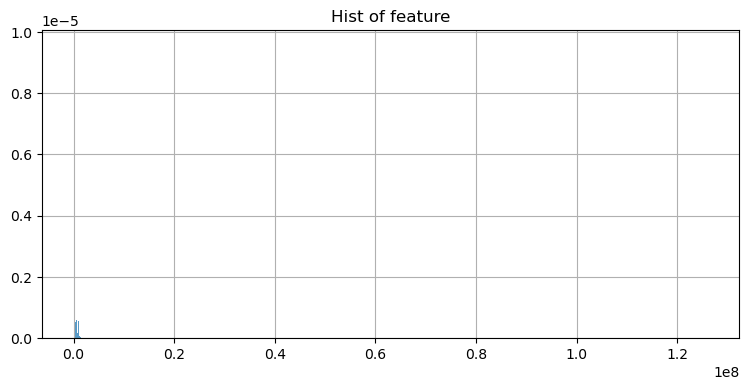


Feature: credit_num


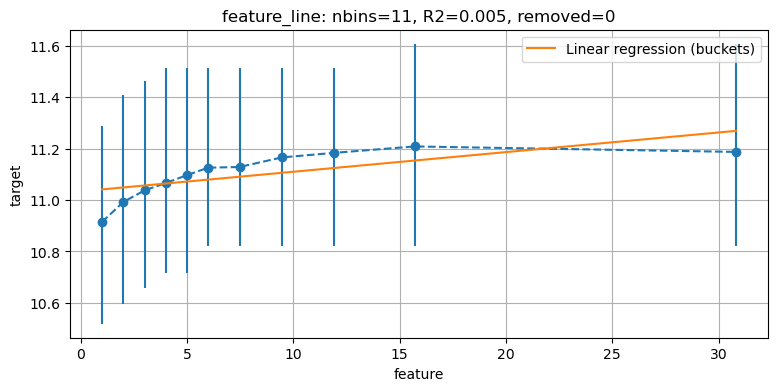

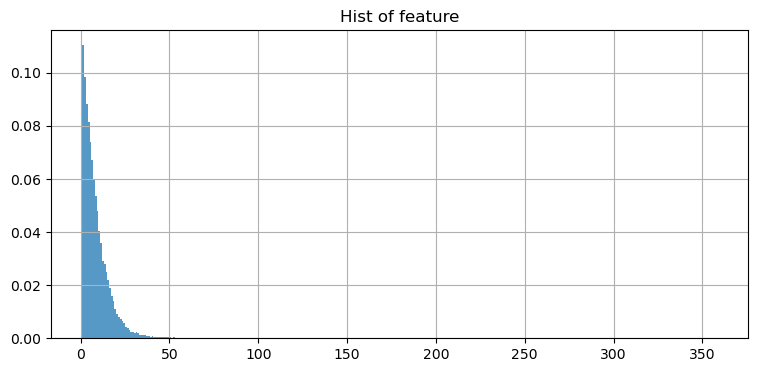


Feature: acc_num


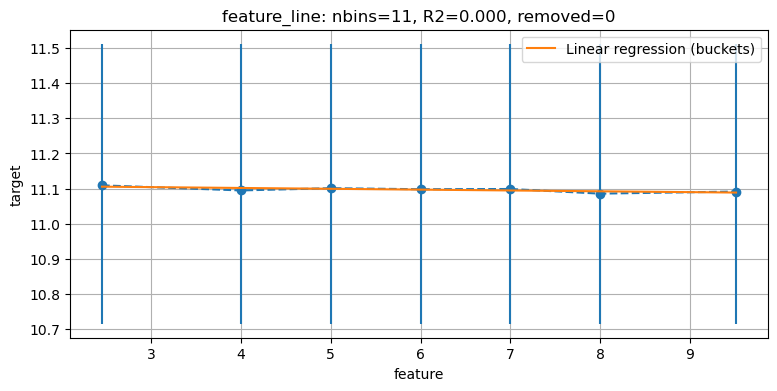

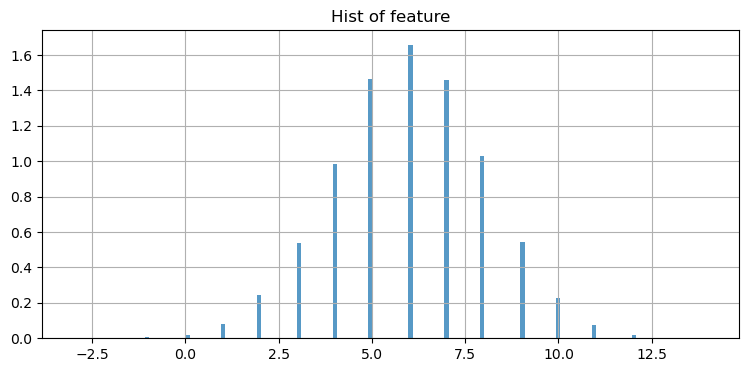


Feature: out_total_amt


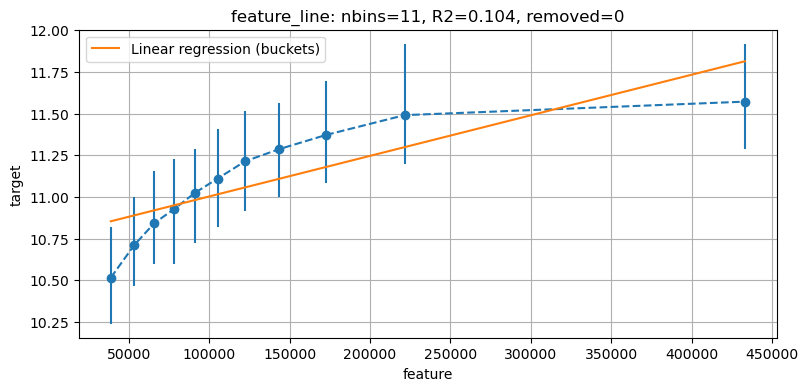

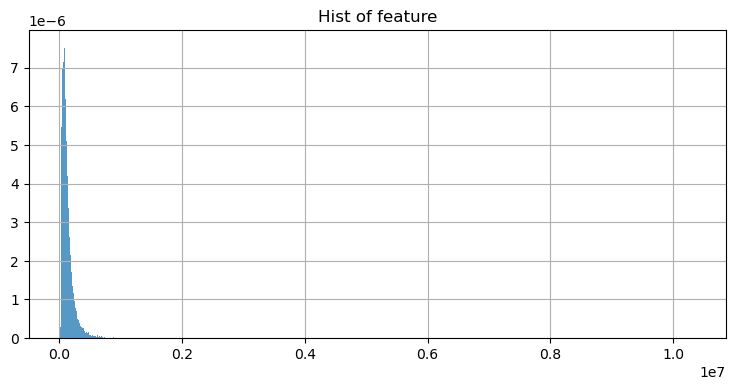

In [36]:
results = []

for f in features:
    if f in ['gender', 'car_own_flg']:
        continue

    print(f"\nFeature: {f}")
    removed, r2 = feature_line(
        feature=X_train[f],
        target=y_train,
        nbins=11
    )
    results.append({
        'feature': f,
        'removed': removed,
        'r2': r2
    })

<a id='task2'></a>
### Задание 2 (1 балл)

Подобрать преобразование и линеаризовать признаки (для визуализации использовать feature_line()). Необходимо обосновать выбор преобразования.

Подсказка: линеаризовать признак age можно разбиением на линейные фрагменты

In [37]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'])#.clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'])#.clip(lower=3000, upper=400000))

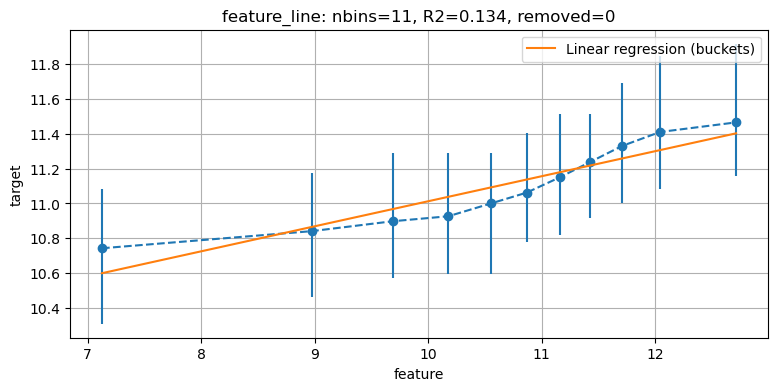

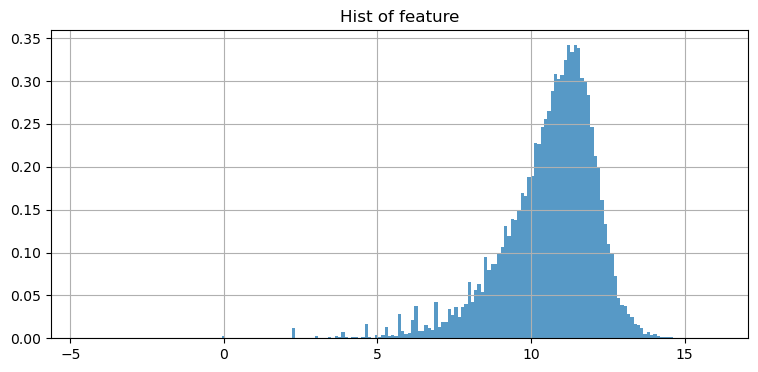

(0, 0.13393125756187674)

In [38]:
feature_line(feature=X_train['in_total_amt_log'], target=y_train, nbins=11)

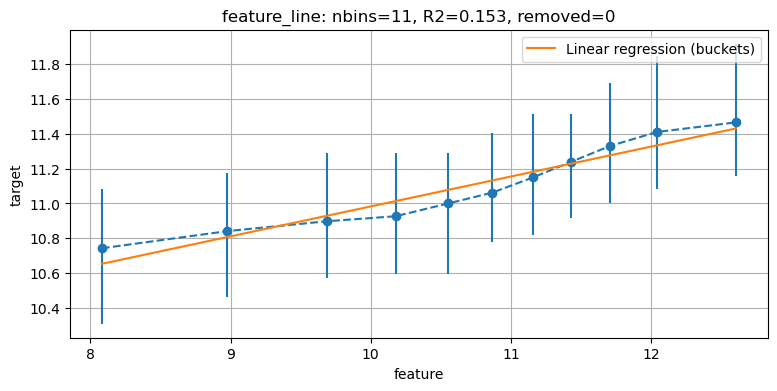

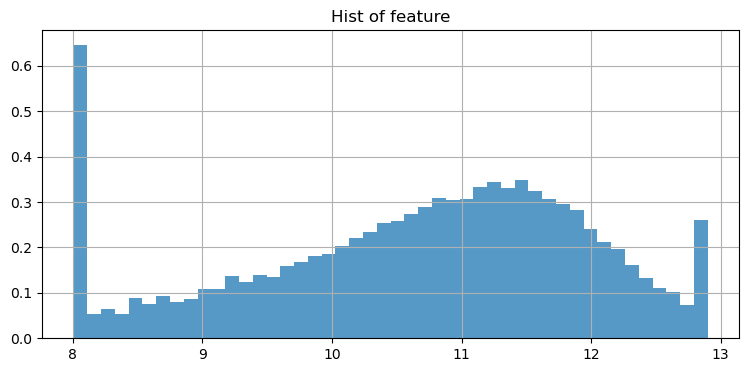

(0, 0.15320477007622624)

In [39]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'].clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'].clip(lower=3000, upper=400000))
feature_line(feature=X_train['in_total_amt_log'], target=y_train, nbins=11)

Преобразования для `in_total_amt` по аналогии с семинаром

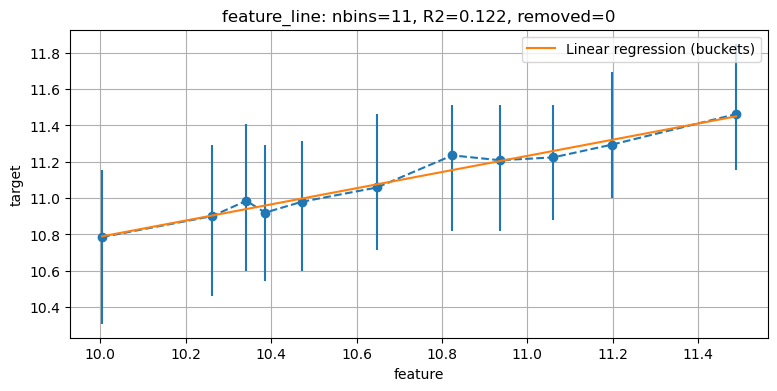

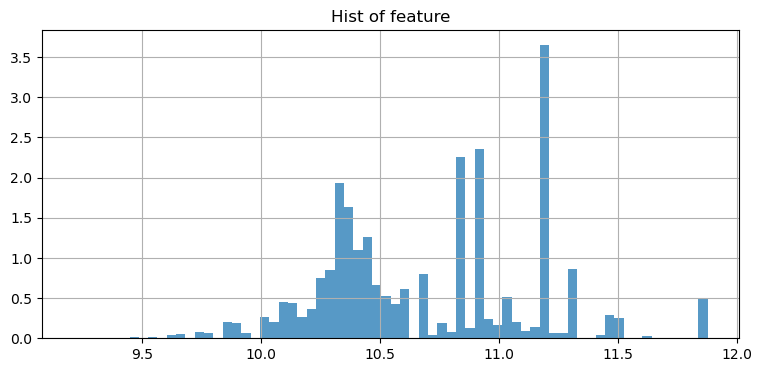

(0, 0.1218742930263399)

In [40]:
X_train["job_salary_log"] = np.log(X_train["job_salary"].clip(lower=10000, upper=200000))
X_test["job_salary_log"] = np.log(X_test["job_salary"].clip(lower=10000, upper=200000))
feature_line(feature=X_train['job_salary_log'], target=y_train, nbins=11)

Признак `job_salary` имеет асимметричное распределение с длинным правым хвостом, а зависимость целевой переменной от него носит нелинейный характер: при больших значениях зарплаты рост дохода замедляется. Логарифмирование с ограничением значений уменьшает влияние выбросов, выпрямляет зависимость и делает признак более подходящим для линейной регрессии. После преобразования зависимость стала ближе к линейной, что подтверждается ростом значения r2 на 0.13 .

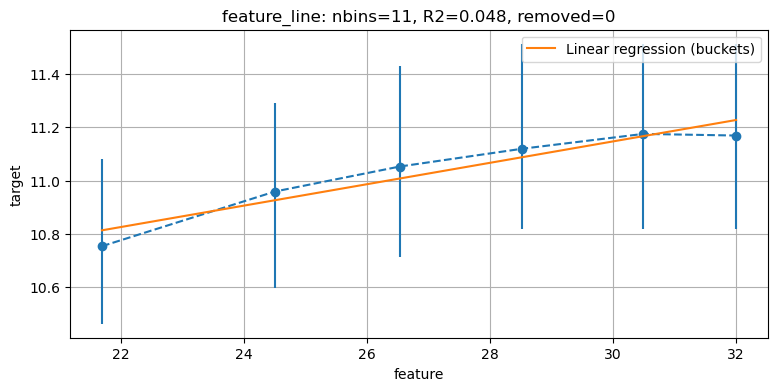

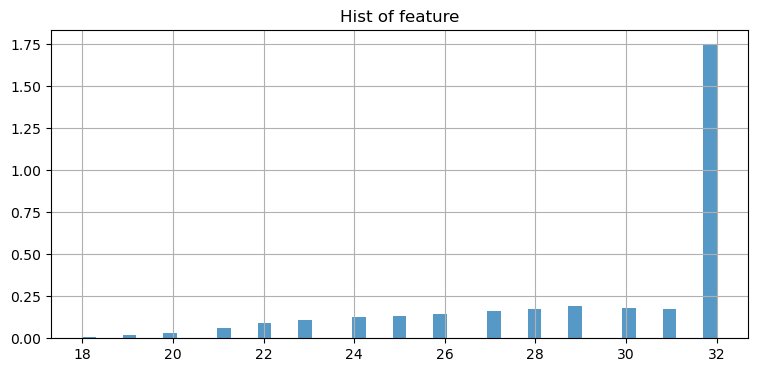

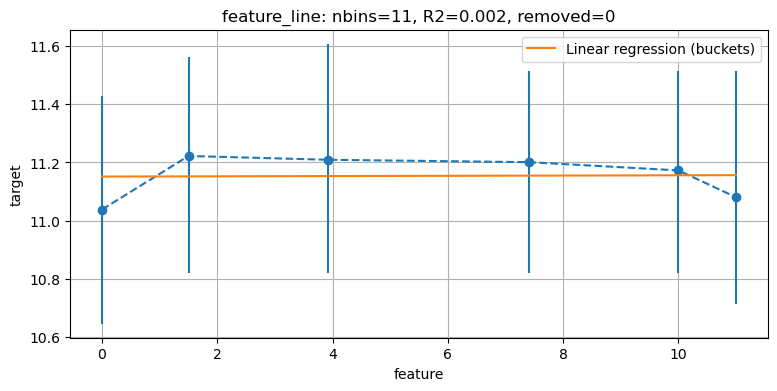

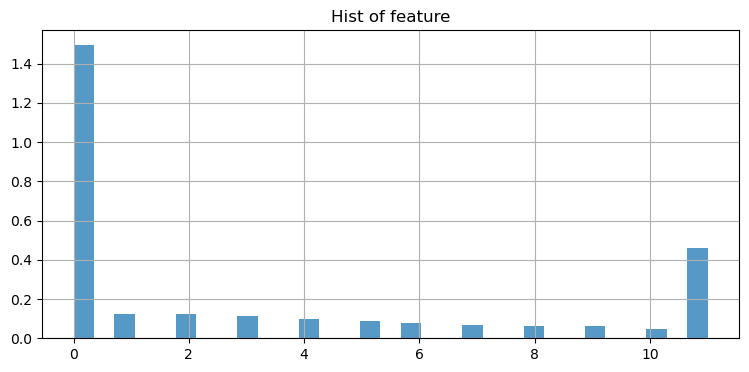

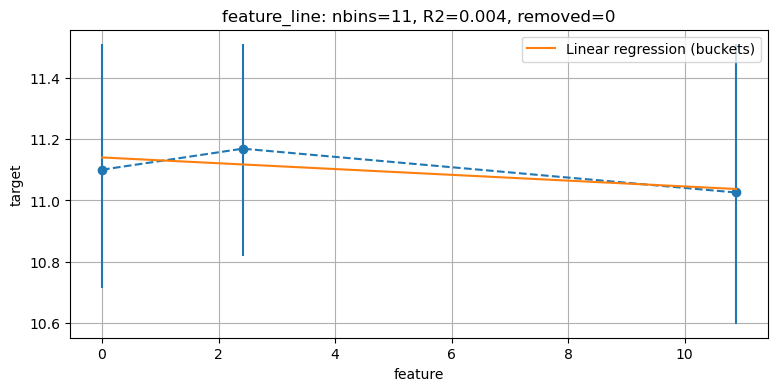

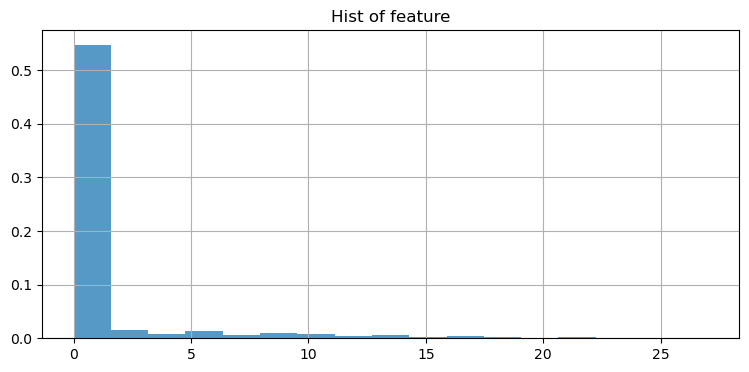

(0, 0.004233796052848571)

In [41]:
X_train["age_18_32"] = X_train["age"].clip(lower=18, upper=32)
X_train["age_32_43"] = (X_train["age"] - 32).clip(lower=0, upper=11)
X_train["age_43_plus"] = (X_train["age"] - 43).clip(lower=0)

X_test["age_18_32"] = X_test["age"].clip(lower=18, upper=32)
X_test["age_32_43"] = (X_test["age"] - 32).clip(lower=0, upper=11)
X_test["age_43_plus"] = (X_test["age"] - 43).clip(lower=0)

X_train = X_train.drop(columns=["age"])
X_test = X_test.drop(columns=["age"])

feature_line(X_train["age_18_32"], y_train)
feature_line(X_train["age_32_43"], y_train)
feature_line(X_train["age_43_plus"], y_train)

Для признака age наблюдается нелинейная зависимость с таргетом: рост значения замедляется с увеличением возраста. Так как распределение возраста не имеет тяжёлых хвостов, логарифмирование не применялось. Вместо этого признак был линеаризован разбиением на возрастные интервалы, внутри которых зависимость близка к линейной.

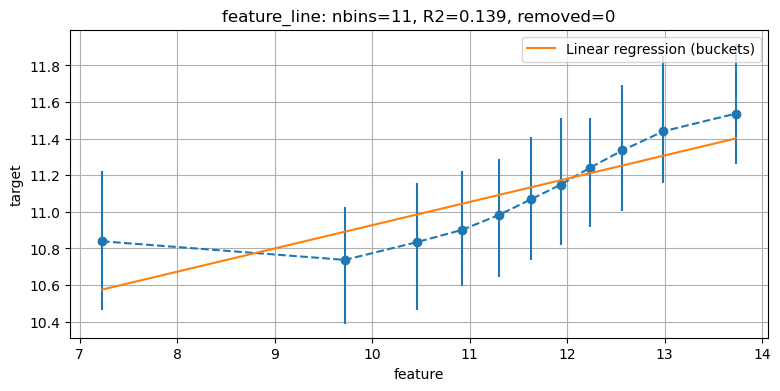

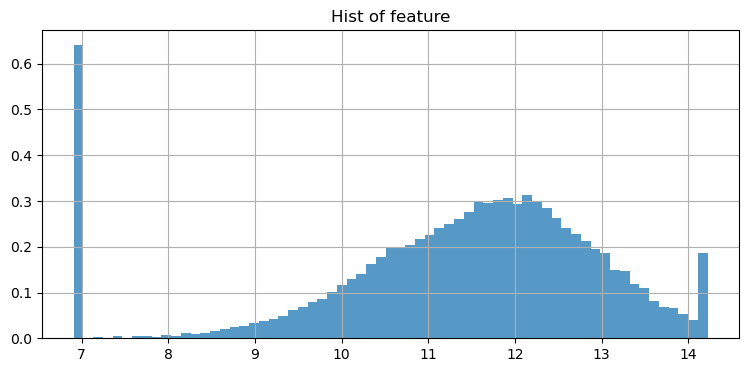

(0, 0.13945022003206076)

In [42]:
X_train["avg_limit_log"] = np.log(X_train["avg_limit"].clip(lower=1000, upper=1500000))
X_test["avg_limit_log"] = np.log(X_test["avg_limit"].clip(lower=1000, upper=500000))
feature_line(X_train["avg_limit_log"], y_train)

Признак avg_limit имеет асимметричное распределение с длинным правым хвостом. Большие значения растягивают шкалу и нарушают линейность зависимости с таргетом. Логарифмирование с ограничением значений уменьшает влияние выбросов, выпрямляет зависимость и делает признак более подходящим для линейной регрессии. После преобразования зависимость стала ближе к линейной, что подтверждается ростом значения r2 на 0.097 .

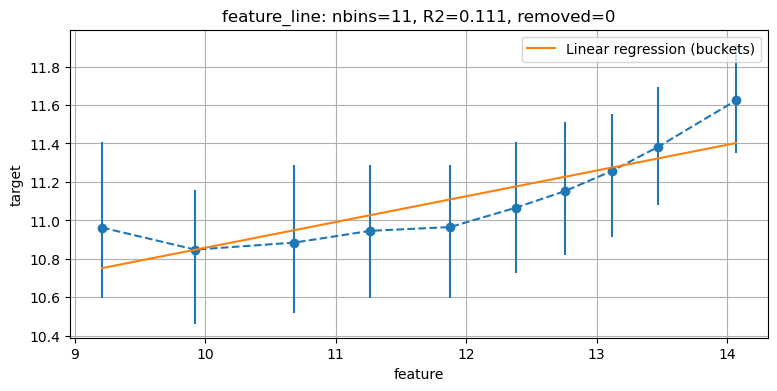

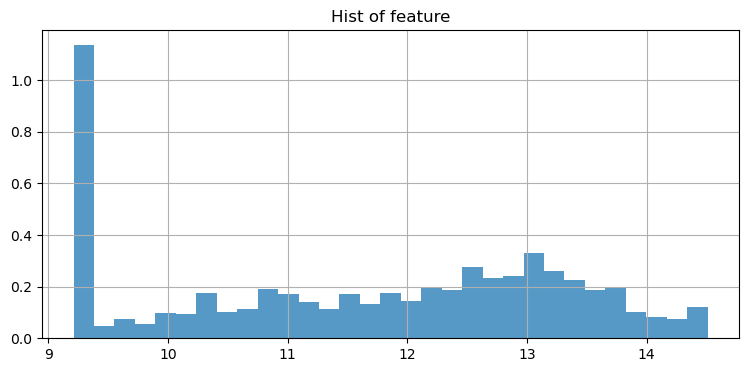

(0, 0.11148241653992597)

In [43]:
X_train["max_limit_log"] = np.log(X_train["max_limit"].clip(lower=10000, upper=2000000))
X_test["max_limit_log"] = np.log(X_test["max_limit"].clip(lower=10000, upper=2000000))
feature_line(X_train["max_limit_log"], y_train)

Признак max_limit имеет асимметричное распределение с длинным правым хвостом. Большие значения растягивают шкалу и нарушают линейность зависимости с таргетом. Логарифмирование с ограничением значений уменьшает влияние выбросов, выпрямляет зависимость и делает признак более подходящим для линейной регрессии. После преобразования зависимость стала ближе к линейной, что подтверждается ростом значения r2 на 0.08 .

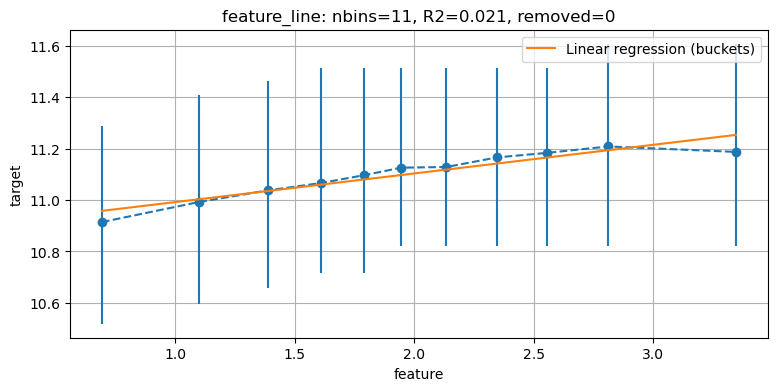

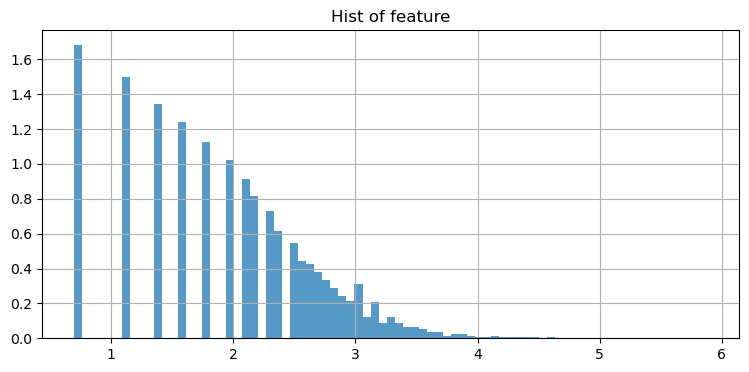

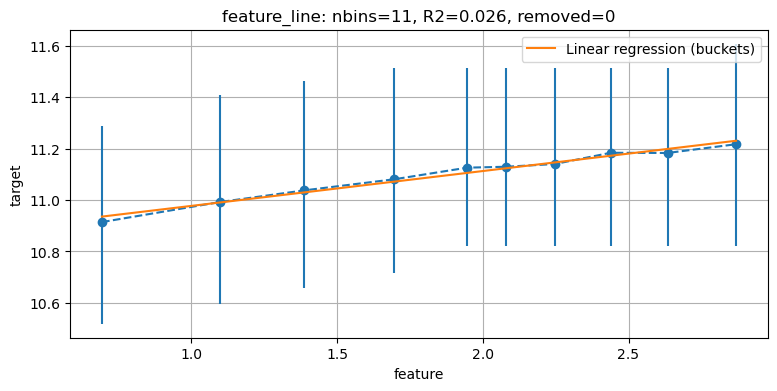

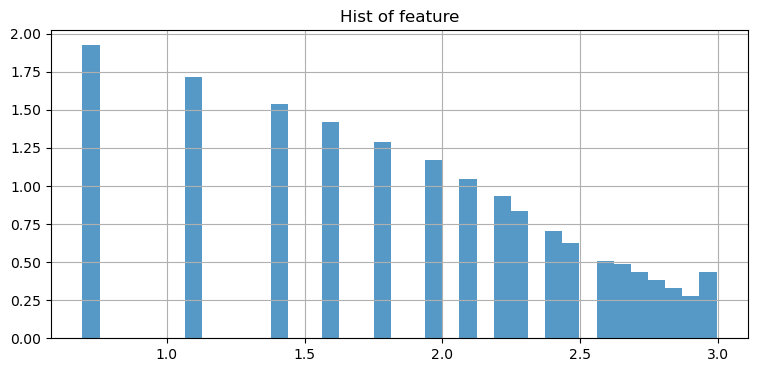

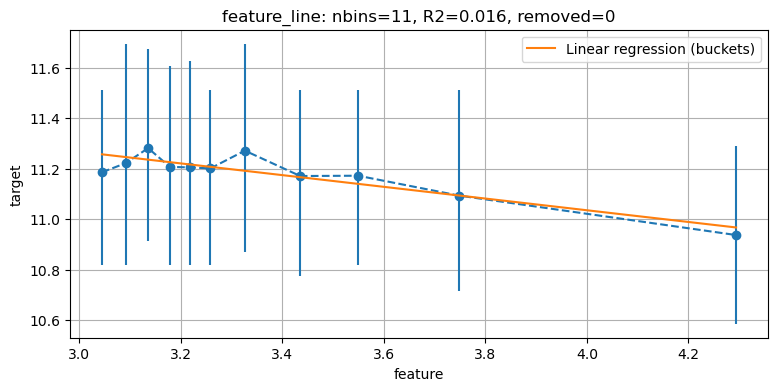

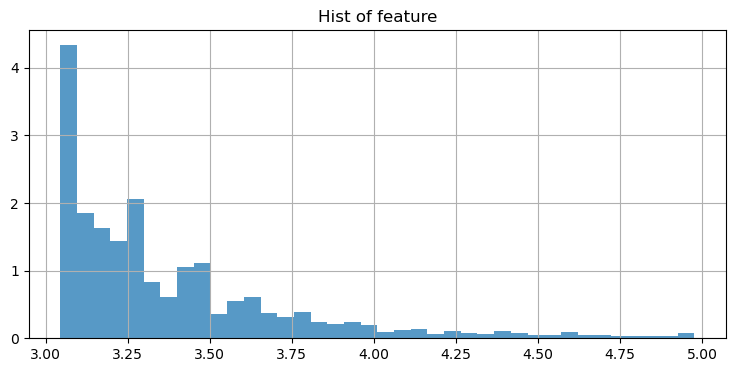

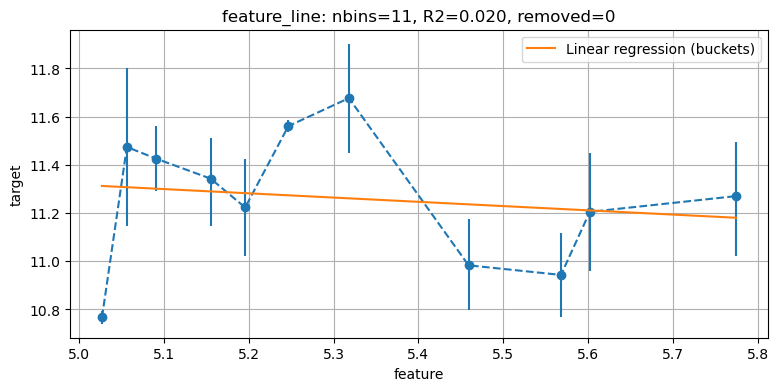

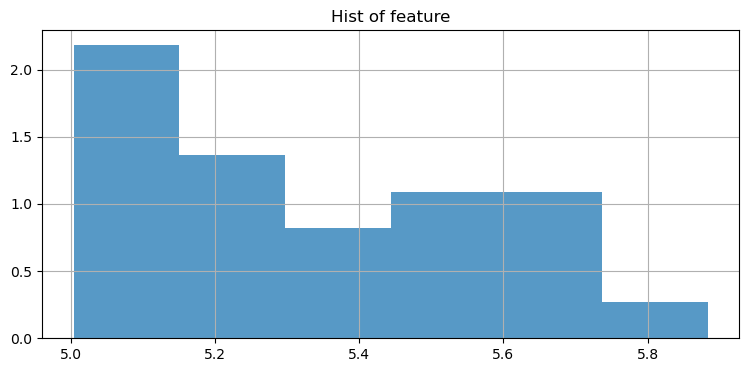

(0, 0.019601564884689338)

In [44]:
credit_num = X_train["credit_num"].values.copy()
target = y_train.copy()

credit_num_log = np.log(credit_num + 1)

feature_line(credit_num_log, target, nbins=11)

mask_1 = credit_num_log <= 3
mask_2 = (credit_num_log > 3) & (credit_num_log <= 5)
mask_3 = credit_num_log > 5
feature_line(credit_num_log[mask_1], target[mask_1], nbins=11)
feature_line(credit_num_log[mask_2], target[mask_2], nbins=11)
feature_line(credit_num_log[mask_3], target[mask_3], nbins=11)

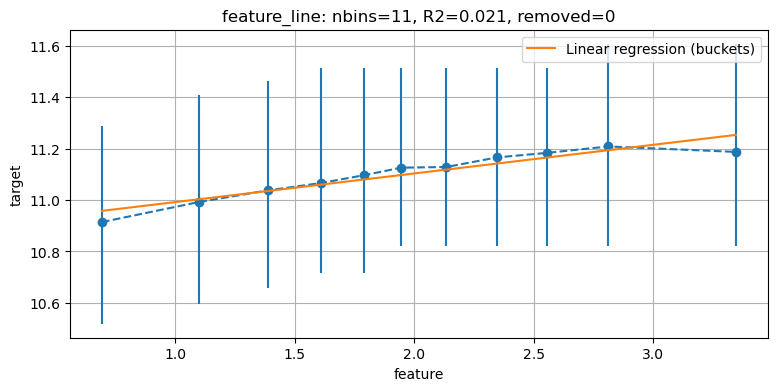

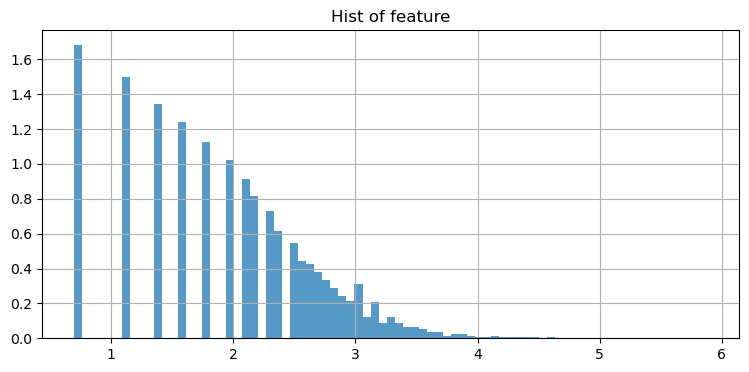

(0, 0.02142479411106646)

In [45]:
X_train["credit_num_log"] = np.log(X_train["credit_num"] + 1)
X_test["credit_num_log"] = np.log(X_test["credit_num"] + 1)

feature_line(X_train["credit_num_log"], y_train, nbins=11)

Признак `credit_num` имеет асимметричное распределение с длинным правым хвостом, а зависимость целевой переменной от него носит нелинейный характер: при больших значениях зарплаты рост дохода замедляется. Логарифмирование с ограничением значений уменьшает влияние выбросов, выпрямляет зависимость и делает признак более подходящим для линейной регрессии. После преобразования зависимость стала ближе к линейной, что подтверждается ростом значения r2 на 0.016 . Разбиение на линейные фрагменты не дало сильной прибавки к r2

Для признака `acc_num` зависимость от целевой переменной близка к линейной, распределение признака симметричное и не содержит выраженного хвоста. Дополнительные преобразования (логарифмирование или разбиение на фрагменты) не улучшают линейность и не увеличивают r2, поэтому признак оставлен в исходном виде.

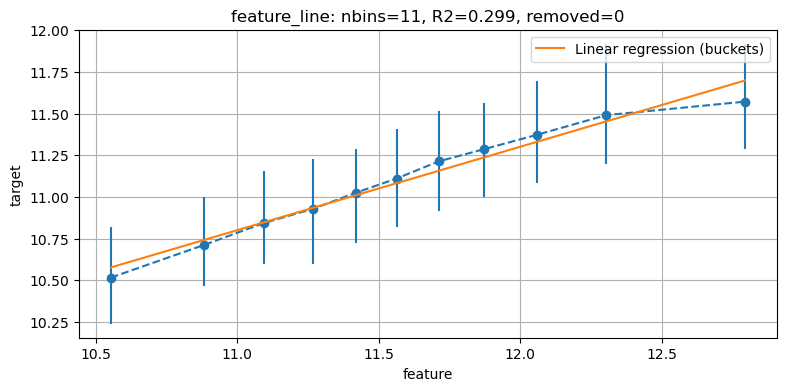

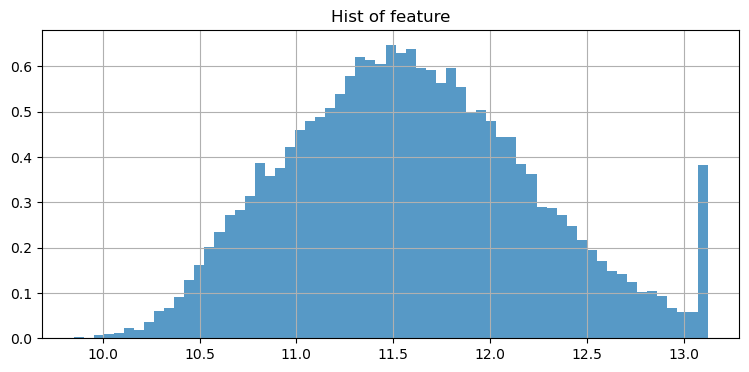

(0, 0.2987734385846915)

In [46]:
X_train["out_total_amt_log"] = np.log(X_train["out_total_amt"].clip(lower=10000, upper=500000))
X_test["out_total_amt_log"] = np.log(X_test["out_total_amt"].clip(lower=10000, upper=500000))

feature_line(X_train["out_total_amt_log"], y_train)

Признак out_total_amt имеет асимметричное распределение с длинным правым хвостом. Большие значения растягивают шкалу и нарушают линейность зависимости с таргетом. Логарифмирование с ограничением значений уменьшает влияние выбросов, выпрямляет зависимость и делает признак более подходящим для линейной регрессии. После преобразования зависимость стала ближе к линейной, что подтверждается ростом значения r2 на 0.195 .

<a id='task3'></a>
##### Задание 3 (1 балл)

Решить проблему гетероскедастичности для признака in_total_amt. Проверить остальные признаки.

Подсказка: обратите внимание на ограничения значений признака in_total_amt

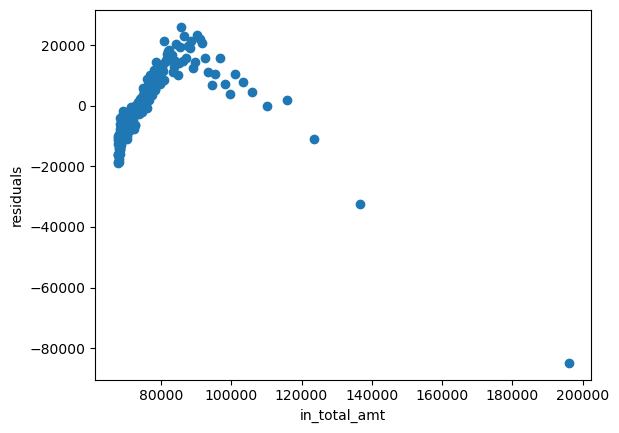

In [47]:
plot_homoscedacity(X_train.in_total_amt, np.exp(y_train),'in_total_amt')
plt.xlabel('in_total_amt')
plt.ylabel('residuals')
plt.show()

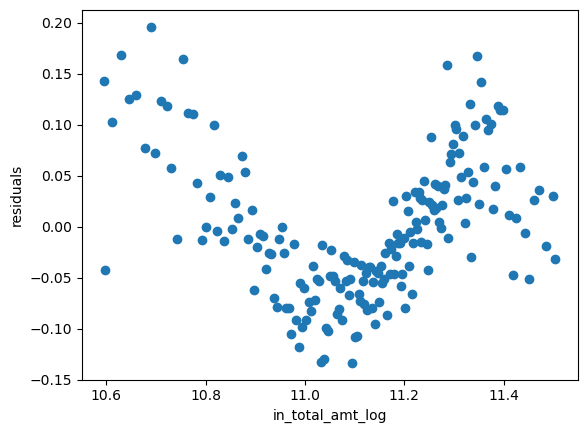

In [48]:
plot_homoscedacity(X_train.in_total_amt_log, y_train,'in_total_amt_log')
plt.xlabel('in_total_amt_log')
plt.ylabel('residuals')
plt.show()

После логарифмирования in_total_amt (с ограничением снизу) и логарифмирования таргета остатки стали заметно стабильнее: абсолютные значения остатков в среднем меньше, и явной зависимости разброса остатков от предсказания больше не видно. То есть гетероскедастичность, которая была на сыром in_total_amt, после преобразования сильно ослабла и условие гомоскедастичности стало выполняться лучше.

In [50]:
X_train.columns

Index(['in_total_amt', 'job_salary', 'gender', 'car_own_flg', 'avg_limit',
       'max_limit', 'credit_num', 'acc_num', 'out_total_amt',
       'in_total_amt_log', 'job_salary_log', 'age_18_32', 'age_32_43',
       'age_43_plus', 'avg_limit_log', 'max_limit_log', 'credit_num_log',
       'out_total_amt_log'],
      dtype='object')

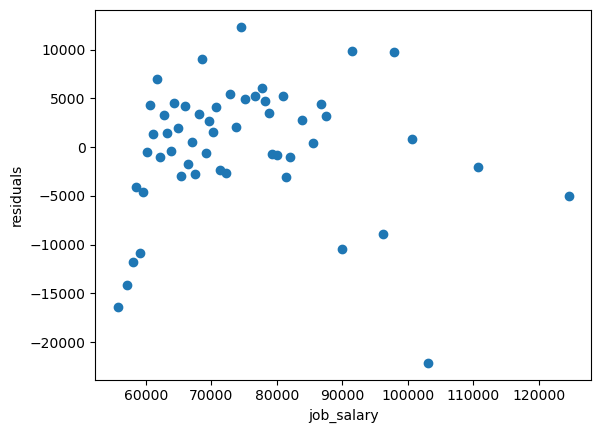

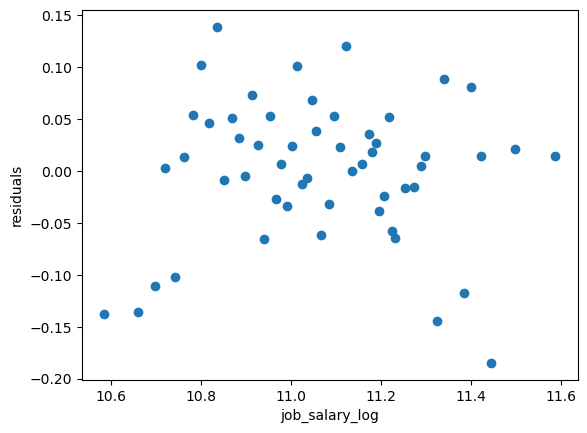

In [59]:
plot_homoscedacity(X_train.job_salary, np.exp(y_train),'job_salary')
plt.xlabel('job_salary')
plt.ylabel('residuals')
plt.show()
plot_homoscedacity(X_train.job_salary_log, y_train,'job_salary_log')
plt.xlabel('job_salary_log')
plt.ylabel('residuals')
plt.show()

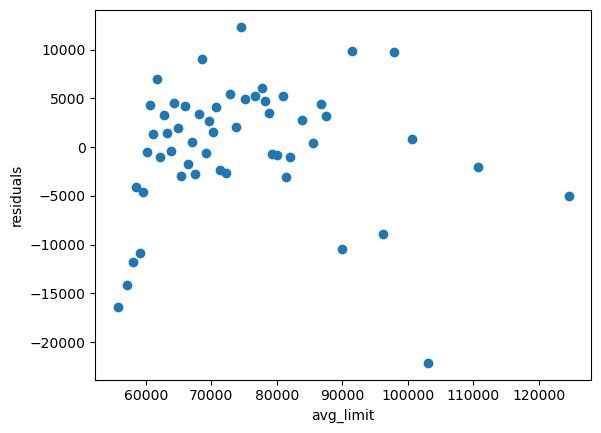

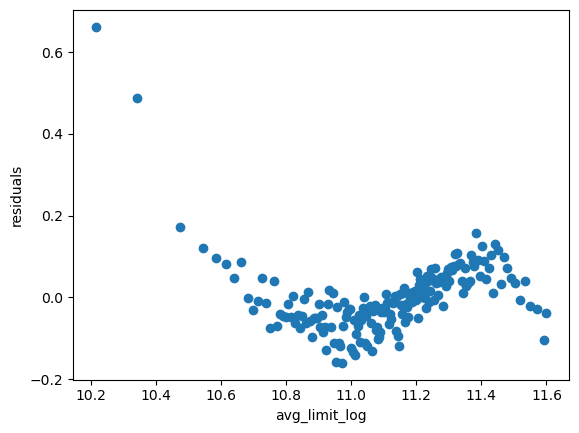

In [54]:
plot_homoscedacity(X_train.job_salary, np.exp(y_train),'avg_limit')
plt.xlabel('avg_limit')
plt.ylabel('residuals')
plt.show()
plot_homoscedacity(X_train.avg_limit_log, y_train,'avg_limit_log')
plt.xlabel('avg_limit_log')
plt.ylabel('residuals')
plt.show()

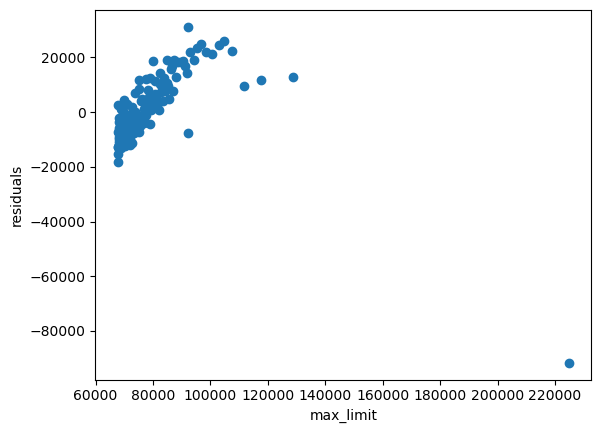

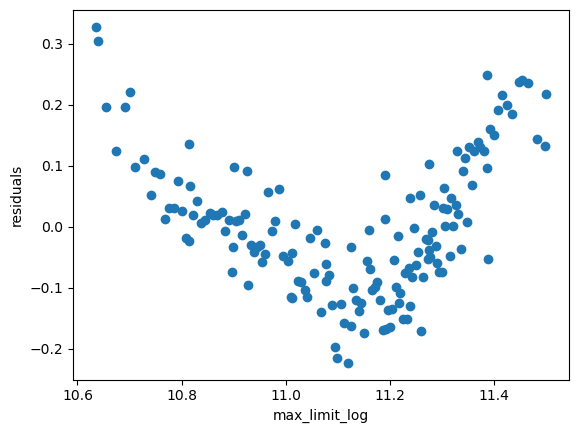

In [55]:
plot_homoscedacity(X_train.max_limit, np.exp(y_train),'max_limit')
plt.xlabel('max_limit')
plt.ylabel('residuals')
plt.show()
plot_homoscedacity(X_train.max_limit_log, y_train,'max_limit_log')
plt.xlabel('max_limit_log')
plt.ylabel('residuals')
plt.show()

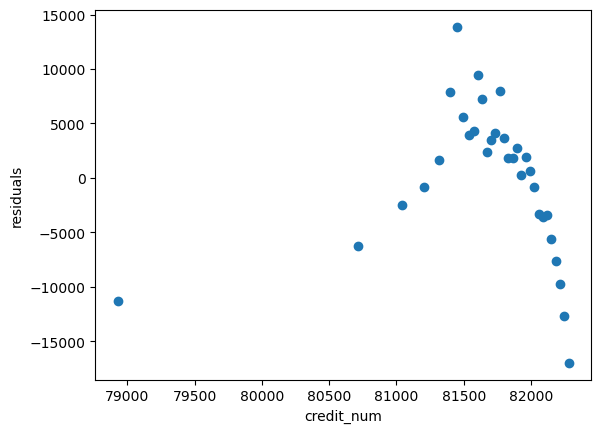

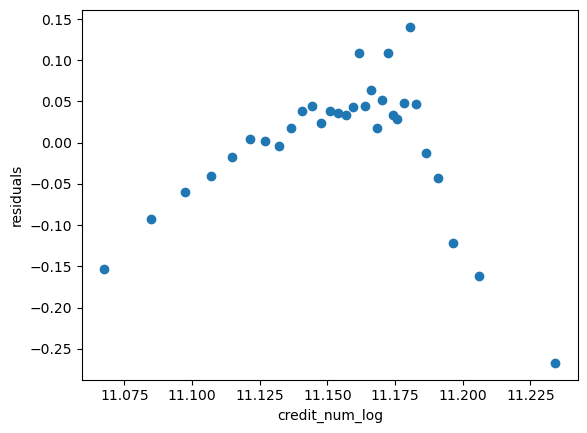

In [56]:
plot_homoscedacity(X_train.credit_num, np.exp(y_train),'credit_num')
plt.xlabel('credit_num')
plt.ylabel('residuals')
plt.show()
plot_homoscedacity(X_train.credit_num_log, y_train,'credit_num_log')
plt.xlabel('credit_num_log')
plt.ylabel('residuals')
plt.show()

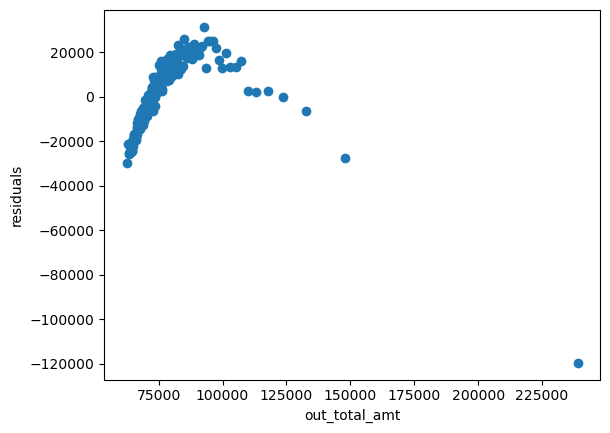

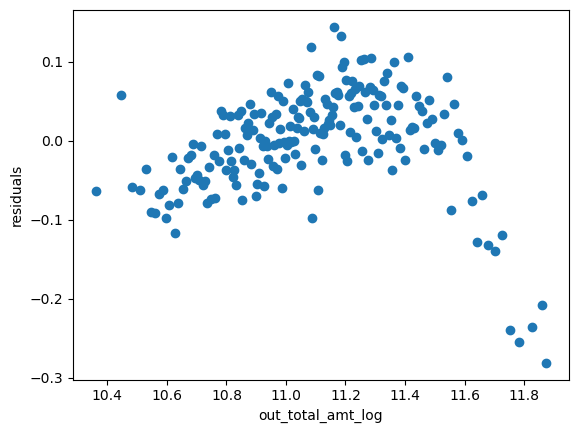

In [58]:
plot_homoscedacity(X_train.out_total_amt, np.exp(y_train),'out_total_amt')
plt.xlabel('out_total_amt')
plt.ylabel('residuals')
plt.show()
plot_homoscedacity(X_train.out_total_amt_log, y_train,'out_total_amt_log')
plt.xlabel('out_total_amt_log')
plt.ylabel('residuals')
plt.show()

После логарифмирования признаков мы можем видеть, что абсолютные значения остатков стали значительно меньше. Нет явной зависимости. До преобразрваний нарушение гомоскедастичность наблюдалось в max_limit, credit_num, out_total_amt: разброс остатков явно зависил от величины предсказания

<a id='task4'></a>
##### Задание 4 (1 балл)

Вычислить VIF для всех признаков. Исключить признаки, линейно зависящие от остальных.

In [93]:
features = X_train.columns.tolist()
pd.DataFrame(data = {'feature':[i for i in features],
                     'VIF':[round(variance_inflation_factor(X_train[features].values,i),2) for i in range(len(features))]}).set_index('feature')

,VIF
feature,
in_total_amt,6655.09
job_salary,1850.61
gender,1.56
car_own_flg,1.29
avg_limit,17668.19
max_limit,1.42
credit_num,4.42
acc_num,9.83
out_total_amt,42629.68


In [95]:
drop_features = [
    "in_total_amt",
    "job_salary",
    "avg_limit",
    "out_total_amt",
    "max_limit",
    "credit_num",
    "age_18_32"
]

X_train_vif = X_train.drop(columns=drop_features)
X_test_vif = X_test.drop(columns=drop_features)
features = X_train_vif.columns.tolist()

<a id='task5'></a>
##### Задание 5 (2 балла)

Построить модель линейной регрессии на рассмотренных и остальных признаках. Не забудьте проверить нормальность остатков вашей модели. 

Вычислить метрику $R^2$ и сравнить с baseline.

In [96]:
features_final = X_train_vif.columns.to_list()
fit_predict(X_train_vif, y_train, X_test_vif, y_test, features_final);

R2_train: 0.3695
R2_test: 0.3786


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


По сравнению с baseline модель заметно улучшилась: r2 на обучающей выборке вырос с 0.26 до 0.37, а на тестовой — с 0.27 до 0.38. Это означает, что добавленные признаки и проведённые преобразования позволяют объяснять большую долю дисперсии целевой переменной. При этом значения r2 на train и test близки друг к другу, что говорит об отсутствии переобучения и нормальной обобщающей способности модели.

<a id='task6'></a>
##### Задание 6 (2 балла)

Рассмотрим выборку для **парной** регрессии: $y = (y_1, \ldots, y_n)\quad x = (x_1, \ldots, x_n)$

С помощью МНК можно найти коэффициенты
$$
\hat y_i = \hat \beta_0 + \hat \beta_1 x_i,\quad \hat \beta_0 = \overline y - \hat \beta_1 \overline x,\quad
\hat \beta_1 = \frac{\sum (x_i - \overline x)(y_i - \overline y)}{\sum (x_i - \overline x)^2}
$$

Доказать, что $$R^2 = \rho^2$$ где 

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

$$
\rho =
\frac{ \frac{1}{n} \sum (x_i - \overline x)(y_i - \overline y)}
{ \sqrt {\frac{1}{n} \sum (x_i - \overline x)^2 \frac{1}{n} \sum (y_i - \overline y)^2 }}
$$

– выборочный коэффициент корреляции.

Для простоты можно предполагать, что $x$ и $y$ **стандартизированы** (имеют нулевое выборочное среднее и единичную выборочную дисперсию).